In [1]:
# ============================================================
# CÉLULA 1: Importação das Bibliotecas e Carregamento dos Dados
# ============================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
print("Bibliotecas carregadas.")

# --- Importar dados preparados ---
DATA_PATH = "../data/model_inputs/model_input.csv"
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset carregado com sucesso: {df.shape[0]} linhas, {df.shape[1]} colunas.")
    print("   Amostra dos dados:")
    display(df.head())
except FileNotFoundError:
    raise RuntimeError(f"ERRO: O arquivo '{DATA_PATH}' não foi encontrado. Execute o notebook 'data_preparation' primeiro.")

Bibliotecas carregadas.
Dataset carregado com sucesso: 124 linhas, 24 colunas.
   Amostra dos dados:


,poi_nome,provincia,latitude,longitude,tempmedanual,precipitacaoanual,ndvi,evi,ndwi,lulccodigo,...,idh,taxaurbanizacao,empregoturismo,distanciaestradaprincipalkm,distanciacidadekm,acessibilidade,tipoviaacesso,infraestrutura,servicosdisponiveis,densidadepopulacionalhabkm
0,Quedas de Calandula,Malanje,-9.074067,16.000316,23.5,1350,0.72,0.64,0.09,20,...,0.522,65.6,4.2,0.5,5.0,Razoavel,Terra Batida,Basica,Energia,77.1
1,Miradouro da Lua,Luanda,-9.221147,13.090001,27.8,320,0.26,0.18,0.12,60,...,0.695,90.1,18.1,2.5,45.0,Boa,Pavimentada,Completa,"Energia, telecom",430.0
2,Museu Kulumbimbi,Zaire,-6.264389,14.245581,26.2,1150,0.78,0.71,0.12,20,...,0.533,44.6,6.7,0.1,1.0,Boa,Pavimentada,Media,"Energia, telecom",39.5
3,Reserva Parcial do Namibe,Namibe,-15.766760,12.399914,25.4,85,0.08,0.05,0.02,60,...,0.571,59.2,8.5,35.0,120.0,Dificil,Terra Batida,Nenhuma,Nenhum,5.1
4,Fortaleza de São Miguel,Luanda,-8.808343,13.223444,27.9,325,0.15,0.12,0.11,50,...,0.702,91.3,15.2,0.0,0.0,Boa,Pavimentada,Completa,"Energia, telecom",423.3


In [2]:
# ===================================================================
# CÉLULA 2: Definição das Variáveis e Pipeline de Pré-processamento
# ===================================================================

# --- 1. Separar o alvo (target) das features ---
# Garantir que a coluna 'idh' existe antes de prosseguir
if 'idh' not in df.columns:
    raise ValueError("A coluna alvo 'idh' não foi encontrada no DataFrame.")
    
X = df.drop(columns=['idh'])
y = df['idh']

# --- 2. Seleção Estratégica de Features ---
# Remover colunas que são apenas identificadores e não devem ser usadas para treinar o modelo.
# 'poi_nome' tem valores únicos e não ajuda a generalizar.
cols_to_drop_from_features = ['poi_nome']
X = X.drop(columns=cols_to_drop_from_features, errors='ignore')
print(f"Colunas identificadoras removidas das features: {cols_to_drop_from_features}")


# --- 3. Identificar os tipos de features restantes ---
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# A 'provincia' é a única feature categórica que queremos tratar.
# Outras colunas de objeto, se existirem, devem ser investigadas.
if 'provincia' in categorical_features:
     print("'provincia' será tratada como feature categórica.")
else:
     print("Nenhuma feature categórica de interesse ('provincia') encontrada.")


print(f"\n Features Numéricas para escalonar ({len(numeric_features)}): {numeric_features[:5]}...") # Mostra apenas as 5 primeiras
print(f"Features Categóricas para OneHotEncode ({len(categorical_features)}): {categorical_features}")

# --- 4. Criar o pré-processador com ColumnTransformer ---
# Define os passos de transformação para cada tipo de coluna.
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline para features numéricas: aplicar escalonamento padrão
        ('num', StandardScaler(), numeric_features),
        
        # Pipeline para features categóricas: aplicar One-Hot Encoding
        # 'handle_unknown='ignore'' é crucial para evitar erros se uma nova categoria aparecer na predição
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (se houver), embora não deva haver.
)

print("\n Pré-processador definido com sucesso.")

Colunas identificadoras removidas das features: ['poi_nome']
'provincia' será tratada como feature categórica.

 Features Numéricas para escalonar (17): ['latitude', 'longitude', 'tempmedanual', 'precipitacaoanual', 'ndvi']...
Features Categóricas para OneHotEncode (5): ['provincia', 'acessibilidade', 'tipoviaacesso', 'infraestrutura', 'servicosdisponiveis']

 Pré-processador definido com sucesso.


Dados divididos em 99 amostras de treino e 25 de teste.

 Modelo treinado com sucesso!

--- Desempenho do Modelo ---
 R² (Coeficiente de Determinação): 0.958
 RMSE (Raiz do Erro Quadrático Médio): 0.018


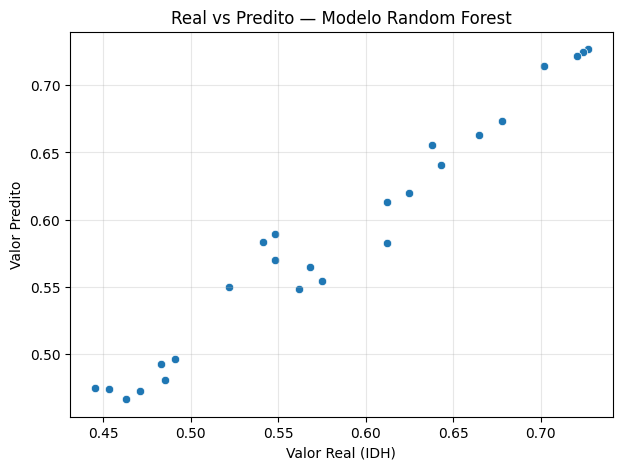

In [3]:
# Treinar modelos
# ============================================================
#  Treinamento e Avaliação do Modelo
# ============================================================

# --- Dividir os dados em conjuntos de treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.\n")

# --- Criar o Pipeline final que une o pré-processador e o modelo ---
# O Pipeline garante que os mesmos passos de pré-processamento sejam aplicados
# de forma consistente durante o treino e a predição.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# --- Treinar o modelo (o pipeline inteiro) ---
pipeline.fit(X_train, y_train)
print(" Modelo treinado com sucesso!")

# --- Avaliar o modelo no conjunto de teste ---
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Desempenho do Modelo ---")
print(f" R² (Coeficiente de Determinação): {r2:.3f}")
print(f" RMSE (Raiz do Erro Quadrático Médio): {rmse:.3f}")

# Visualização: comparação real vs predito
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valor Real (IDH)")
plt.ylabel("Valor Predito")
plt.title("Real vs Predito — Modelo Random Forest")
plt.grid(True, alpha=0.3)
plt.show()

 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   poi_nome                     124 non-null    object 
 1   provincia                    124 non-null    object 
 2   latitude                     124 non-null    float64
 3   longitude                    124 non-null    float64
 4   tempmedanual                 124 non-null    float64
 5   precipitacaoanual            124 non-null    int64  
 6   ndvi                         124 non-null    float64
 7   evi                          124 non-null    float64
 8   ndwi                         124 non-null    float64
 9   lulccodigo                   124 non-null    int64  
 10  altitude                     124 non-null    int64  
 11  populacao                    124 non-null    int64  
 12  densidadepop                 124 non-null    float64
 13 

,latitude,longitude,tempmedanual,precipitacaoanual,ndvi,evi,ndwi,lulccodigo,altitude,populacao,densidadepop,pibpercapita,idh,taxaurbanizacao,empregoturismo,distanciaestradaprincipalkm,distanciacidadekm,densidadepopulacionalhabkm
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,1.240000e+02,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,-11.425490,14.724174,24.070161,892.508065,0.417984,0.379435,0.123306,43.467742,740.040323,4.010790e+05,105.414516,2258.283871,0.566403,57.549194,10.441935,16.048387,52.103226,113.325806
std,3.256886,2.687281,3.111923,454.067677,0.262043,0.239003,0.063524,18.958421,724.471744,9.219525e+05,170.517240,1175.953592,0.084251,19.402252,7.756111,26.906944,86.788488,176.118216
min,-17.816700,11.766000,17.500000,60.000000,0.020000,0.020000,0.010000,10.000000,2.000000,3.450000e+02,0.100000,1050.600000,0.445000,22.300000,1.200000,0.000000,0.000000,0.100000
25%,-14.755250,13.228000,21.400000,472.500000,0.110000,0.100000,0.080000,30.000000,25.000000,8.765000e+03,5.250000,1388.025000,0.491750,40.425000,4.100000,0.100000,1.000000,5.250000
50%,-11.899669,13.549500,24.650000,1000.000000,0.460000,0.410000,0.100000,50.000000,595.000000,3.456700e+04,23.550000,1867.750000,0.555000,58.100000,7.800000,3.450000,15.000000,28.500000
75%,-8.816275,15.611675,26.900000,1265.000000,0.642500,0.590000,0.160000,60.000000,1325.000000,1.490428e+05,123.225000,2793.225000,0.618750,71.025000,18.125000,22.000000,66.250000,135.400000
max,-4.833000,24.301000,28.100000,1800.000000,0.890000,0.810000,0.300000,80.000000,2620.000000,3.150000e+06,789.500000,5310.600000,0.732000,93.500000,26.100000,150.000000,500.000000,789.500000



 Valores ausentes:


poi_nome                       0
provincia                      0
latitude                       0
longitude                      0
tempmedanual                   0
precipitacaoanual              0
ndvi                           0
evi                            0
ndwi                           0
lulccodigo                     0
altitude                       0
populacao                      0
densidadepop                   0
pibpercapita                   0
idh                            0
taxaurbanizacao                0
empregoturismo                 0
distanciaestradaprincipalkm    0
distanciacidadekm              0
acessibilidade                 0
tipoviaacesso                  0
infraestrutura                 0
servicosdisponiveis            0
densidadepopulacionalhabkm     0
dtype: int64

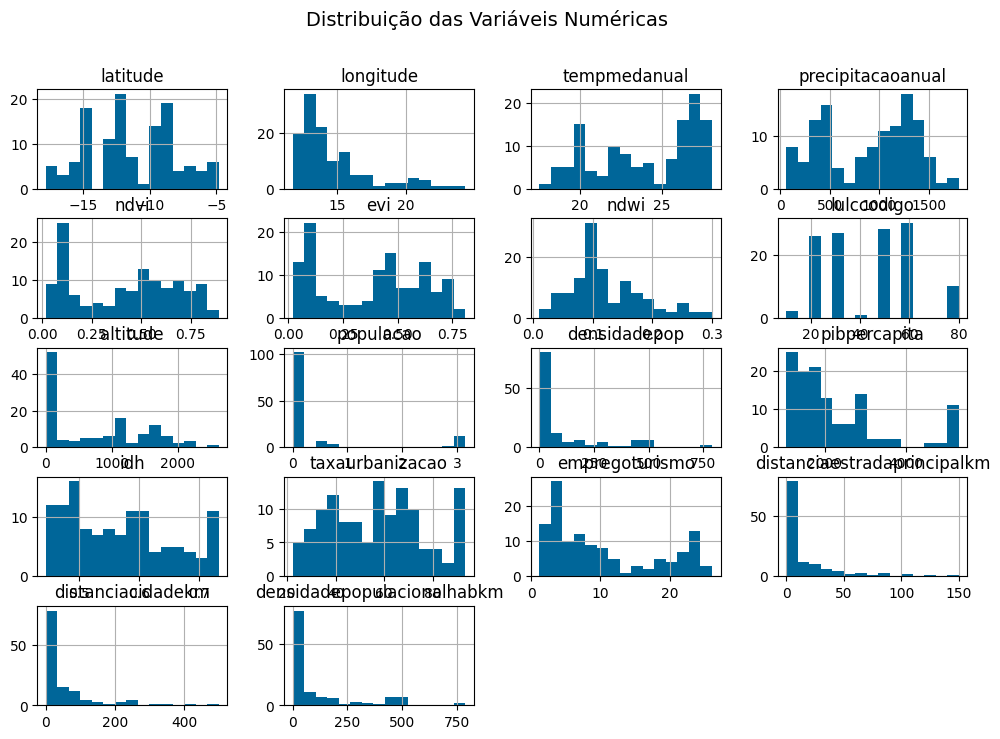

In [4]:
#  Análise exploratória dos dados
# ============================================================

print(" Informações gerais:")
df.info()

print("\n Estatísticas descritivas:")
display(df.describe())

# Verificar valores ausentes
print("\n Valores ausentes:")
display(df.isnull().sum())

# Visualização rápida da distribuição das variáveis
df.hist(figsize=(12, 8), bins=15, color="#006699")
plt.suptitle("Distribuição das Variáveis Numéricas", fontsize=14)
plt.show()

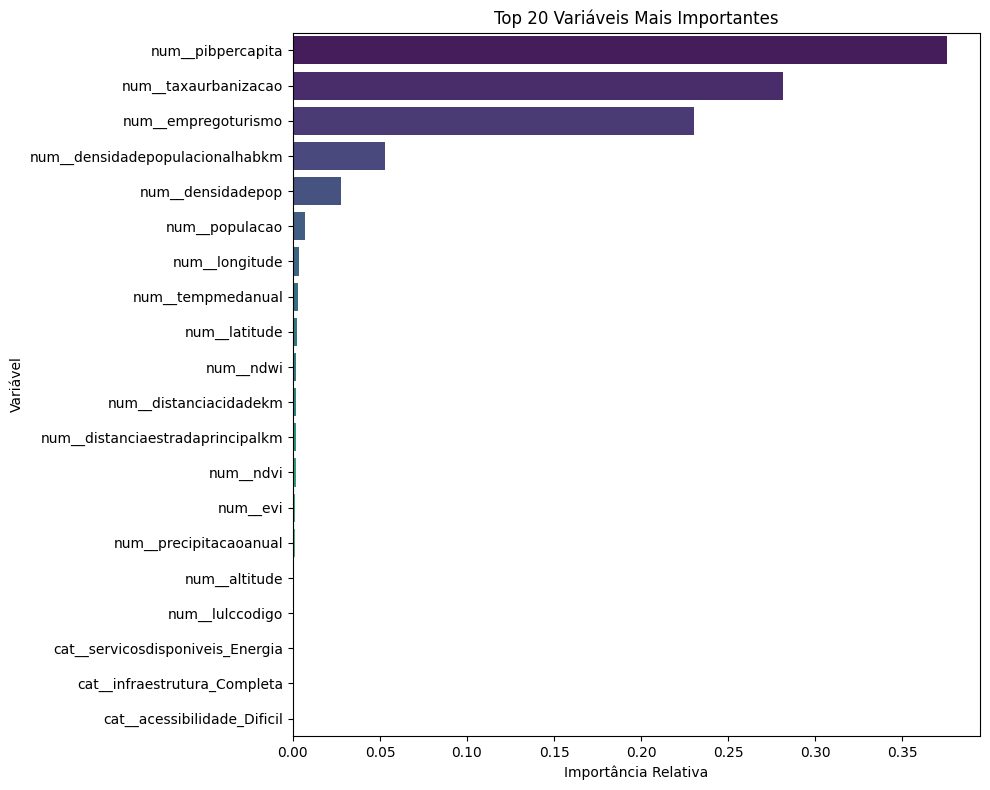

In [5]:
# Avaliar variáveis mais importantes


# Extrair os nomes das features DEPOIS da transformação do pré-processador
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extrair as importâncias do modelo treinado dentro do pipeline
importances = pipeline.named_steps['model'].feature_importances_

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'feature': feature_names_out,
    'importance': importances
}).sort_values('importance', ascending=False)

# --- Gerar o gráfico ---
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title("Top 20 Variáveis Mais Importantes")
plt.xlabel("Importância Relativa")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [6]:
# Salvar modelo
# ============================================================
#  Salvamento do Modelo (Pipeline Completo)
# ============================================================

# Definir o caminho e o nome do arquivo do modelo
MODEL_DIR = "../data/model_inputs"
MODEL_PATH = os.path.join(MODEL_DIR, "tourism_model.pkl")

# Criar o diretório se ele não existir
os.makedirs(MODEL_DIR, exist_ok=True)

# Salvar o objeto 'pipeline' inteiro. Ele contém tudo o que é necessário
# para fazer novas previsões: o pré-processador e o modelo treinado.
joblib.dump(pipeline, MODEL_PATH)

print(f" Pipeline completo salvo com sucesso em: {MODEL_PATH}")

 Pipeline completo salvo com sucesso em: ../data/model_inputs\tourism_model.pkl


In [7]:
# Entrega esperada: models/tourism_model.pkl
# ============================================================
# Verificação da Entrega
# ============================================================

# Este bloco apenas confirma que o arquivo foi criado no local esperado.
if os.path.exists(MODEL_PATH):
    print(f"\n Entrega confirmada: o arquivo '{os.path.basename(MODEL_PATH)}' existe no diretório '{MODEL_DIR}'.")
else:
    print(f"\n Atenção: o arquivo do modelo não foi encontrado no local esperado.")


 Entrega confirmada: o arquivo 'tourism_model.pkl' existe no diretório '../data/model_inputs'.
